## Assessing Landcover Classification Performance

Finally, we can assess the accuracy of the model featuring 3 positive / 3 negative NDVI components.  This step takes the classifications "learned" via NMF and compares them side-by-side with the ground truth comparison dataset.  We start by pairing up images into sets where the first image path points to the classifications learned by the NMF model, and the second image path point to the corresponding ground truth image that was clipped from the comparison dataset.  Then, we can easily iterate over these image sets to assess the model's accuracy in the context of each train and test image.

In [14]:
data_filepath = str(u"C:\\Users\\Alison Link\\Documents\\INET4710\\FinalProjectData\\")

train_images = [
    ['TRAIN',
        data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TRAIN.tif', # just west of downtown St. Paul (by St. Paul campus)  
        data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TRAIN.tif'
    ]
]

test_images = [
    ['TEST0',
         data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TEST0.tif', # downtown Minneapolis
         data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TEST0.tif'
    ],
    ['TEST1',
         data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TEST1.tif', # just east of downtown Minneapolis
         data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TEST1.tif'
    ],
    ['TEST2',
         data_filepath + u'classified_images\\StPaulCampus_3neg_3pos_035NDVI_cutoff\\StPaulCampus_3pos_3neg_TEST2.tif', # downtown St. Paul
         data_filepath + u'ground_truth_comparison_data\\comparison_clips\\comparison_clip_TEST2.tif'
    ]
]

In [130]:
# General utilities
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Raster & geographic data manipulation libraries
import rasterio

### NDVI accuracy assessment

We can start with a "quick and dirty" version of an accuracy assessment that simply looks at the question: _Did the modeling process help us accurately discern the difference between vegetation and non-vegetation land use classes?_  

We address this question by grouping together NDVI-postive and NDVI-negative land use classes from both the training/test data and the "ground truth" comparison data, and seeing where they overlap.  The function below compares pixels from the train/test images with the corresponding pixels from the "ground truth" images and identifies pixels where the NDVI classifications do not align.  The dictionary mapping below indicates which classification numbers from each of the datasets are associated with vegetation (NDVI-positive) and non-vegetation (NDVI-negative) for the purpose of assessing alignment.

In [87]:
# Dictionary to map which classes are NDVI positive and which are negative in the training and 
# "ground truth" data
ndvi_dict = {
    'train_test_ndvi_pos': [1, 2, 3],
    'gt_ndvi_pos': [1, 6, 7, 8, 9, 10],
    'train_test_ndvi_neg': [0, 4, 5, 6],
    'gt_ndvi_neg': [2, 3, 4, 5, 11, 12]
}

def calculate_ndvi_classification_performance(img_sets, ndvi_dict):
    ''' Does the model discern correctly between pixels that are NDVI positive and NDVI negative? 
    Take image sets as an input (with the target image first, and the ground truth comparison 
    image second).  Compare where they match and where they don't. '''
    
    fig, axs = plt.subplots(1, len(img_sets), figsize=(20, 5))
    
    for i in range(len(img_sets)):
        classified_img = rasterio.open(img_sets[i][1])
        gt_img = rasterio.open(img_sets[i][2])

        classification = classified_img.read(1).astype('int')
        gt_class = gt_img.read(1).astype('int')

        ndvi_classification_accuracy = np.empty(classified_img.shape, dtype=rasterio.int8)
        ndvi_classification_accuracy = np.where(
            np.logical_or(np.logical_and(np.isin(classification, ndvi_dict['train_test_ndvi_pos']), 
                                         np.isin(gt_class, ndvi_dict['gt_ndvi_pos'])),
                          np.logical_and(np.isin(classification, ndvi_dict['train_test_ndvi_neg']), 
                                         np.isin(gt_class, ndvi_dict['gt_ndvi_neg']))) , 1, 0) # 1 if they match, 0 if they don't

        accuracy_pct = round((np.sum(ndvi_classification_accuracy) / classification.size) * 100, 3) 
        
        misclass_colors = ListedColormap(['orangered', 'white'])
        axs[i].imshow(ndvi_classification_accuracy, cmap=misclass_colors)
        axs[i].set_title(img_sets[i][0] + ": NDVI classification accuracy = " + str(accuracy_pct))

Looking at the output below, the pixels in red represent pixels that are on the "wrong" side of the NDVI positive/negative boundary: these are pixels that have been classified as vegetation where the ground truth data suggests they are non-vegetation, or pixels that have been classified as non-vegetation where the ground truth data suggests the opposite.  

We see that, in general, the NDVI misclassification seems to occur on the boundaries of objects, where one land use class bumps up against another.  This is not entirely surprising, as these are the regions where there is some genuine ambiguity: pixels themselves--particularly in liminal regions between classes--are not "pure" representations of substances.  Instead, each pixel represents a "mixing" of reflectance from the earth's surface before it hits a sensor and is encoded back into discretized pixel units.  The remote sensing literature is full of references to the conundrums of "spectral mixing/unmixing", which is an unavoidable phenomenon in remotely sensed imagery (see: Ma, et al., 2014; Keshava & Mustard, 2002). Because of this, a bit of misclassification "noise" around the edges of landcover classes should not be overly concerning to us.  In fact, the accuracy we see here is particularly impressive when we consider that the classifications we're comparing were derived from vastly different methodologies--the "ground truth" data representing an object-based image analysis approach, compared to the unsupervised pixel-by-pixel NMF-based classification approach.

There are a few regions where the NDVI misclassifications appear more systematic.  For example, there is a region in the upper left corner of the training image where there are several large, misclassified areas.  Examining this discrepancy in a GIS reveals that this is likely due to annual change in agricultural growth that is not represented in the "ground truth" comparison data.  The "ground truth" dataset classifies this region as agricultural land, but at the time when the training image was captured, this land happend to be lying fallow.  In some respect, then, the NMF model was actually "more" correct in its classification than the "ground truth": the model classified this land as dirt/soil, which happened to be more true to the state of the land at the time of image capture!  There also appears to be some systematic inaccuracy in the lower left-hand corner of the first test image (TEST0).  Examining this region in a GIS reveals that the "ground truth" data is classifying this area as a lake/pond, while the NMF model is labeling this as field/turf.  This could be due to some kind of algae growth or lake bed plant growth that is reflecting in this region.  Again, it seems likely that the NMF model is actually _more_ correct, and provides some additional nuance that "ground truth" dataset has obscured.

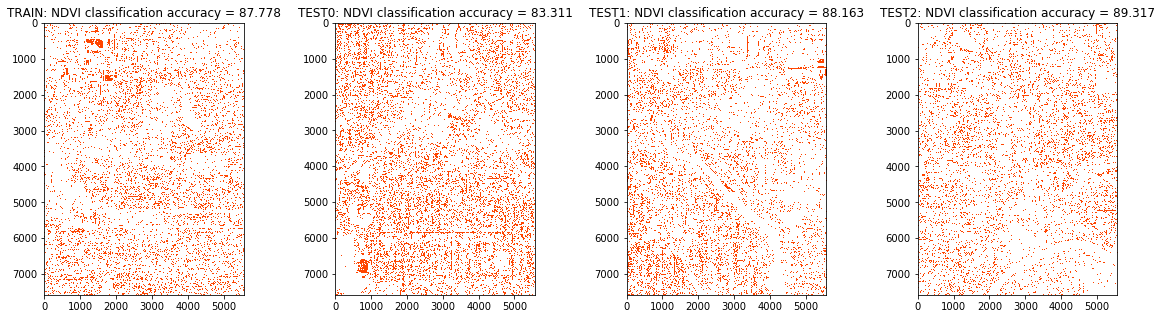

In [88]:
calculate_ndvi_classification_performance(train_images + test_images, ndvi_dict)

### Class-by-class accuracy assessment

Next, we can conduct an accuracy assessment broken down by each separate landcover classification value.  Note that we need to skip one of the classes "learned" in the NMF model ("class 2 = turf/fields"), because the ground truth data does not separate this out as a distinct class for comparison.  All of the other classes learned during NMF model building have reasonable corollaries in the ground truth dataset.  We construct a dictionary mapping to connect the classifications learned via NMF to their corollaries available in the ground truth data.  Then, we can compare how well the NMF classifications match the ground truth classifications.

In [89]:
# Dictionary to map categories for comparison between train/test classification comparable values in the 
# "ground truth" data.  The train/test class labels are listed first, the ground truth classes are listed second
# in the mapping dictionary.
classification_compare_dict = {
    'water': [[0], [5, 9, 10, 11]],
    'grass/agriculture': [[1], [1, 8, 9]],
    #'turf/fields': [[2], []],
    'trees': [[3], [6, 7]],
    'dirt/soil/sand': [[4, 6], [2, 12]],
    'asphalt/buildings': [[5], [3, 4]]
}

def calculate_classification_performance(img_sets, classification_compare_dict):
    
    fig, axs = plt.subplots(len(img_sets), len(classification_compare_dict), figsize=(20, 5 * len(img_sets)), squeeze=False)
    
    for i in range(len(img_sets)):
        classified_img = rasterio.open(img_sets[i][1])
        gt_img = rasterio.open(img_sets[i][2])

        classification = classified_img.read(1).astype('int')
        gt_class = gt_img.read(1).astype('int')

        for j, class_label in enumerate(classification_compare_dict.keys()):

            gt_class_pixels = np.where(np.isin(gt_class, classification_compare_dict[class_label][1]), 1, 0)
            #print(gt_class_pixels)
            
            misclassified_pixels = np.where(np.logical_and(
                np.isin(gt_class, classification_compare_dict[class_label][1]), # find areas where the ground truth matches the selected class
                np.isin(classification,classification_compare_dict[class_label][0], invert=True)), # look for where the classified image does not align
                                            1, 0)

            accuracy_pct = round(100 - ((np.sum(misclassified_pixels) / np.sum(gt_class_pixels)) * 100), 3)
            gt_colors = ListedColormap(['white', 'black'])
            axs[i][j].imshow(gt_class_pixels, cmap=gt_colors)
            
            misclass_colors = ListedColormap(['white', 'orangered'])
            axs[i][j].imshow(misclassified_pixels, cmap=misclass_colors, alpha=.5)
            
            axs[i][j].set_title(img_sets[i][0] + ": " + str(class_label) + "\nAccuracy = " + str(accuracy_pct))

The visual below shows the **recall** performance of the NMF model, broken down by class.  The shaded pixels represent all members of a particular class, as determined by the ground truth dataset.  The pixels in grey represent places where the NMF model's classification aligns with the ground truth dataset's classification.  The pixels in red represent the areas where the NMF model's classification diverges from the ground truth dataset.  Here, we start to notice some patterns:

* The model being assessed here appears to be most accurate when it comes to identifying **trees** and **dirt/soil/sand**.

* The model performs moderately well for detecting **asphalt/buildings**.  

* The model performs less well when detecting **grass/agriculture**.  There are places--particularly around areas like golf courses--where it seems to be mistakenly labeling grass as tree cover.  It's possible that a model with 3 positive NDVI classes, like this model, is too simplistic in how it separates vegetation, and could be improved by adding allowing the model to "learn" additional NDVI-positive components during training.

* The model _can_ be reasonably accurate at identifying **water** (see the TEST1 image as an example), but its accuracy rate for water is quite variable.  This is likely because the model is very sensitive to the NVDI water cutoff value used during training.  The NMF model appears to be making two main "mistakes" when it comes to identifying water: 1) it appears to have trouble discerning the difference when water has high reflectance due to glint/glare, and mistakes this water for asphalt; 2) in some cases, the model actually appears to be _more_ accurate than the ground truth data, as it picks out algae/wetland areas and labels them as "grass".  Unfortunately, this particular model is not able to distinguish the difference between algae/wetlands and grass; this could be something that emerges, however, if we to allow the model to "learn" more features/classes during the initial training process.

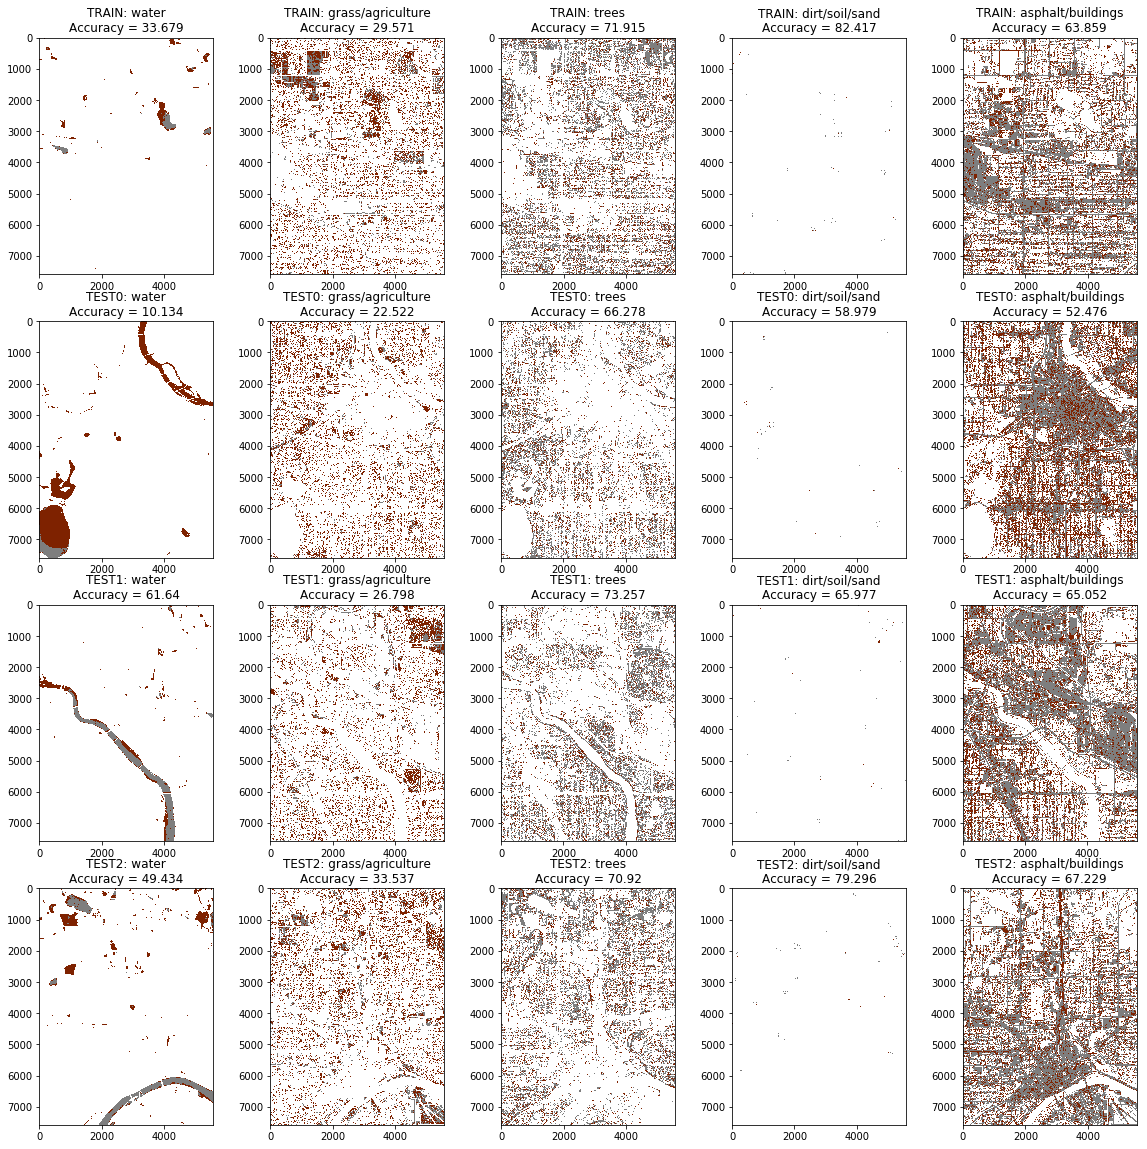

In [84]:
calculate_classification_performance(train_images + test_images, classification_compare_dict)

## Conclusion

This project assessed the viability of applying an unsupervised NMF classification approach to imagery that has lower spectral fidelity than the hyperspectral imagery where these techniques are often applied.  The imagery used in this project has the advantage of being relatively simple to understand--even for a practitioners without advanced skillsets--and is readily manipulable in Python.  On the whole, the NMF modeling approach _was_ able to extract meaningful landcover classifications from the 4-band NAIP imagery with minimal effort on the part of the analyst, other than determining the relevant hyperparameter for the NDVI water cutoff value and deciding how many positive/negative NDVI components to use when training the model.

More work needs to be done to see how well NMF models learned on a specific set of training images can generalize to data captured at different time periods and different regions.  Also, because NMF is a pixel-by-pixel analysis, it does not segment out vectorized "objects" that are often useful in landcover analysis.  Further research is needed to understand how this unsupervised NMF approach could potentially be combined with segmentation algorithms to extract vectorized "objects" with particular landcover classifiations from an image.

All in all, however, the unsupervised NMF approach outlined here represents a promising starting point for quickly obtaining basic landcover classifications for imagery where labels/ground truth inputs are time-prohibitive or costly to obtain.  To summarize, here are some "pros" and "cons" of this unsupervised NMF landcover classification approach:

#### Pros:

* Requires no class label inputs in order to extract patterns from input data.  Supervised approaches often require laborious manual effort to produce labeled data to use as inputs for landcover classification tasks; the NMF aapproach requires no initial labeling effort on the part of the analyst.

* The classes extracted by NMF do, indeed, appear to align with some of the common spectral reflectance patterns discussed in remote sensing literature (ex: grass/turf, trees, asphalt, etc.).  This means that NMF is able to extract "meaningful" landcover classes from the data alone, and these classes can be reasonably comprehensible to the analyst versed in remote sensing literature.

#### Cons:

* Cannot easily distinguish between buildings and roads.  Because buildings are roads are often covered with the same materials (asphalt, for example), they cannot be systematically differentiated via a pixel-by-pixel classification approach.  They may require some additional, object-based analytical approach to help differentiate.

* Requires some judgement on the part of the user to decide where to set the NDVI water cutoff threshold for what should be considered water prior to training the model.  The NDVI water cutoff threshold is a hyperparameter that can vary based on the quality of the image and the atmospheric/reflectance conditions on the day the image was captured.  More work need to be done to see if this parameter could be selected programmatically in an informed way, without manual intervention on the part of the user.

* The NMF model may "learn" classes that, while they are distinct enough to justifiably be separated, are not particularly meaningful to humans.  (For example: Separating red/clay roofs from other building roofs.)

